In [1]:
## Import Libraries
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torchvision

In [2]:
#Seed for Recreation of Results. Determining Randomness
random_seed = random.randint(0,10000)
print("Random Seed : ", random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)

Random Seed :  7460


In [3]:
#Arguments 
#data = '/home/shubhansh/Work/Datasets/celebA/img_align_celeba'
workers = 4
batch_size = 128
img_size = 64
n_channel = 3
n_z = 100
n_fpg = 64
n_fpd = 64
n_epochs = 15
lr = 0.0002
beta1 = 0.5
ngpu = 1
device = torch.device("cuda:0")
unsupervised_factor = 1

In [4]:
#  Data Loader with resize,crop and Normalization

#Transform
transform  = transforms.Compose([transforms.Resize(img_size),transforms.CenterCrop(img_size),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

#Load Dataset with applied transform

#Cifar 10
dataset = torchvision.datasets.CIFAR10(root='/home/shubhansh/Work/Datasets/', train=True,
                                        download=True, transform=transform)

dataloader_unlabel = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=workers,drop_last=True)
##Used for sampling for Generator(Semi Supervised GAN resamples while training generator)
dataloader_unlabel_gen = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=workers,drop_last=True)
dataloader_label = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=workers,drop_last=True)




Files already downloaded and verified


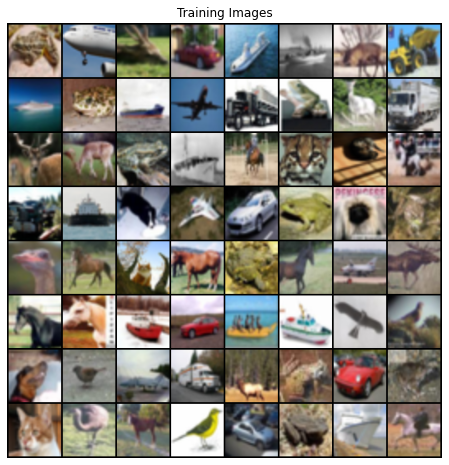

In [5]:
#Sample Batch for Visualization
real_batch = next(iter(dataloader_unlabel))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64],padding=2,normalize=True).cpu(),(1,2,0)))

In [6]:
# Weight Initialization for All networks(as per paper)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv')!=-1:
        nn.init.normal_(m.weight.data,0.0,0.02)
    elif classname.find('BatchNorm')!=-1:
        nn.init.normal_(m.weight.data,1.0,0.02)
        nn.init.constant_(m.bias.data,0)
    elif classname.find('Linear')!=-1:
        nn.init.normal_(m.weight.data,0.0,0.02)

In [7]:
##Log Sum exponential function
##This function will be used to apply BCE Loss later

def log_sum_exp(x):
    m = torch.max(x, dim = 1)[0]
    return m + torch.log(torch.sum(torch.exp(x - m.unsqueeze(1)), dim = 1))

In [8]:
## Generator Architecture
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.convt1 = nn.ConvTranspose2d(n_z,n_fpg*8,4,1,0,bias = False)
        self.bn1 = nn.BatchNorm2d(n_fpg*8)

        self.convt2 = nn.ConvTranspose2d(n_fpg*8,n_fpg*4,4,2,1,bias = False)
        self.bn2 = nn.BatchNorm2d(n_fpg*4)

        self.convt3 = nn.ConvTranspose2d(n_fpg*4,n_fpg*2,4,2,1,bias = False)
        self.bn3 = nn.BatchNorm2d(n_fpg*2)

        self.convt4 = nn.ConvTranspose2d(n_fpg*2,n_fpg,4,2,1,bias = False)
        self.bn4 = nn.BatchNorm2d(n_fpg)

        self.convt5 = nn.ConvTranspose2d( n_fpg, n_channel, 4, 2, 1, bias=False)

    
    def forward(self,input):

        o1_1 = self.convt1(input)
        o1_2 = self.bn1(o1_1)
        o1_3 = F.relu(o1_2)

        o2_1 = self.convt2(o1_3)
        o2_2 = self.bn2(o2_1)
        o2_3 = F.relu(o2_2)

        o3_1 = self.convt3(o2_3)
        o3_2 = self.bn3(o3_1)
        o3_3 = F.relu(o3_2)

        o4_1 = self.convt4(o3_3)
        o4_2 = self.bn4(o4_1)
        o4_3 = F.relu(o4_2)

        output = F.tanh(self.convt5(o4_3))

        return output

    def layer_output_shape(self):

        with torch.no_grad():
            dummy = torch.zeros([1,n_z,1,1],device=device)
            print(dummy.shape)
            dummy = self.convt1(dummy)
            print(dummy.shape)
            dummy = self.bn1(dummy)
            print(dummy.shape)
            dummy = F.relu(dummy)
            print(dummy.shape)
            print("---------------")
            
            dummy = self.convt2(dummy)
            print(dummy.shape)
            dummy = self.bn2(dummy)
            print(dummy.shape)
            dummy = F.relu(dummy)
            print(dummy.shape)
            print("---------------")

            dummy = self.convt3(dummy)
            print(dummy.shape)
            dummy = self.bn3(dummy)
            print(dummy.shape)
            dummy = F.relu(dummy)
            print(dummy.shape)
            print("---------------")

            dummy = self.convt4(dummy)
            print(dummy.shape)
            dummy = self.bn4(dummy)
            print(dummy.shape)
            dummy = F.relu(dummy)
            print(dummy.shape)
            print("---------------")

            dummy = F.tanh(self.convt5(dummy))
            print(dummy.shape)
            print("---------------")
            del dummy


In [9]:
# Generator to GPU
netG = Generator().to(device)
# Initialization of Weights of Generator
netG.apply(weights_init)

Generator(
  (convt1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)

In [10]:
## Discriminator Architecture
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.conv1 = nn.Conv2d(n_channel,n_fpd,4,2,1,bias = False)
        self.bn1 = nn.BatchNorm2d(n_fpd)

        self.conv2 = nn.Conv2d(n_fpd,n_fpd*2,4,2,1,bias = False)
        self.bn2 = nn.BatchNorm2d(n_fpd*2)

        self.conv3 = nn.Conv2d(n_fpd*2,n_fpd*4,4,2,1,bias = False)
        self.bn3 = nn.BatchNorm2d(n_fpd*4)

        self.conv4 = nn.Conv2d(n_fpd*4,n_fpd*8,4,2,1,bias = False)
        self.bn4 = nn.BatchNorm2d(n_fpg*8)

        self.conv5 = nn.Conv2d( n_fpd*8, 10, 4, 1, 0, bias=False)
    
    def forward(self,input):

        o1_1 = self.conv1(input)
        o1_2 = self.bn1(o1_1)
        o1_3 = F.leaky_relu(o1_2,0.2)

        o2_1 = self.conv2(o1_3)
        o2_2 = self.bn2(o2_1)
        o2_3 = F.leaky_relu(o2_2,0.2)

        o3_1 = self.conv3(o2_3)
        o3_2 = self.bn3(o3_1)
        o3_3 = F.leaky_relu(o3_2,0.2)

        o4_1 = self.conv4(o3_3)
        o4_2 = self.bn4(o4_1)
        o4_3 = F.leaky_relu(o4_2,0.2)
        ##for feature matching for generator
        
        
        output = (self.conv5(o4_3))
        self.last_layer_features = output.view(output.size(0),-1)
        return output.view(output.size(0),-1)

    
    
    def layer_output_shape(self,h,w=None):
        if w==None:
            w=h
        with torch.no_grad():
            dummy = torch.zeros([1,n_channel,h,w],device=device)
            print(dummy.shape)
            dummy = self.conv1(dummy)
            print(dummy.shape)
            dummy = self.bn1(dummy)
            print(dummy.shape)
            dummy = F.leaky_relu(dummy,0.2)
            print(dummy.shape)
            print("---------------")
            

            dummy = self.conv2(dummy)
            print(dummy.shape)
            dummy = self.bn2(dummy)
            print(dummy.shape)
            dummy = F.leaky_relu(dummy,0.2)
            print(dummy.shape)
            print("---------------")

            dummy = self.conv3(dummy)
            print(dummy.shape)
            dummy = self.bn3(dummy)
            print(dummy.shape)
            dummy = F.leaky_relu(dummy,0.2)
            print(dummy.shape)
            print("---------------")

            dummy = self.conv4(dummy)
            print(dummy.shape)
            dummy = self.bn4(dummy)
            print(dummy.shape)
            dummy = F.leaky_relu(dummy,0.2)
            print(dummy.shape)
            print("---------------")

            output = (self.conv5(dummy))
            print(output.shape)
            print("---------------")
            output = output.view(output.size(0),-1)
            print(output.shape)
            print("---------------")
            del dummy
            del output


In [11]:
# Discriminator to GPU
netD = Discriminator().to(device)
# Discriminator Weight Initialization
netD.apply(weights_init)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 10, kernel_size=(4, 4), stride=(1, 1), bias=False)
)

In [12]:
print("--Discriminator Layer Shape--")
print("=============================")
netD.layer_output_shape(64)
print("\n")
print("--Generator Layer Shape--")
print("=========================")
netG.layer_output_shape()

--Discriminator Layer Shape--
torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
---------------
torch.Size([1, 128, 16, 16])
torch.Size([1, 128, 16, 16])
torch.Size([1, 128, 16, 16])
---------------
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 8, 8])
---------------
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 4, 4])
---------------
torch.Size([1, 10, 1, 1])
---------------
torch.Size([1, 10])
---------------


--Generator Layer Shape--
torch.Size([1, 100, 1, 1])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 4, 4])
---------------
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 8, 8])
---------------
torch.Size([1, 128, 16, 16])
torch.Size([1, 128, 16, 16])
torch.Size([1, 128, 16, 16])
---------------
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
---------------
torch.Size([1, 3

In [13]:
## Binary Cross Entropy Loss
supervised_criterion = nn.CrossEntropyLoss()
generator_loss = nn.MSELoss()

##For Results
fixed_batch = torch.randn(64,n_z,1,1,device=device)
## Assign 1 to Real Images
real_label = 1
## Assign 0 to Fake Images
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [14]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

In [18]:
print("Starting Training .....")

for epoch in range(n_epochs):
    label_batch = iter(dataloader_label)
    gen_data_unsupervised = iter(dataloader_unlabel_gen)
    for i,data_unsupervised in enumerate(dataloader_unlabel,0):

        ### Discriminator Update

        ## Making Zero Gradient in Start(Remove residual gradient from previous epoch)
        netD.zero_grad()

        ## Passing Real Batch

        #Supervised Training
        label_x,label_y = next(label_batch)
        label_x  = label_x.to(device)
        label_y = label_y.to(device)

        output_label = netD(label_x)
        loss_sup = supervised_criterion(output_label,label_y)

        ##Unsupervised Loss

        unlabel_x= data_unsupervised[0].to(device)
        b_size = unlabel_x.shape[0]
        label = torch.full((b_size,),real_label,device=device)


        output_unlabel = netD(unlabel_x)
        real_features = netD.last_layer_features.detach().mean(dim=0).view(-1)
        ##Error Calculation for Unsupervised case :

        ##For Class 1 : log(z/1+z)
        logz_unlabel = log_sum_exp(output_unlabel)
        D_unsup_real = -torch.mean(logz_unlabel) + torch.mean(F.softplus(logz_unlabel))

        ## Generate fake images using generator

        noise = torch.randn(b_size,n_z,1,1,device= device)
        fake_data = netG(noise)
        ## Passing Fake Batches
        output_fake = netD(fake_data.detach())
        logz_fake = log_sum_exp(output_fake)
        ##For Class 0 : log(1/1+z) and Add both the losses
        ##Scale Unsup loss to half
        D_unsup_fake= torch.mean(F.softplus(logz_fake))
        D_unsup = 0.5*(D_unsup_real + D_unsup_fake)

        ## Total Discriminator Error
        netD_error = loss_sup + unsupervised_factor*D_unsup
        netD.zero_grad()
        netD_error.backward()
        ## Update the Discriminator
        optimizerD.step()


        ### Generator Update

        netG.zero_grad()
        netD.zero_grad()
        noise = torch.randn(b_size,n_z,1,1,device= device)
        fake_data = netG(noise)
        output_fake = netD(fake_data)
        
        logz_fake = log_sum_exp(output_fake)
        DG_fake = torch.mean(F.softplus(logz_fake))
        fake_features = netD.last_layer_features.mean(dim=0).view(-1)
        unlabel_x_gen= next(gen_data_unsupervised)[0].to(device)
        output_unlabel_gen = netD(unlabel_x_gen)
        real_features_gen = netD.last_layer_features.detach().mean(dim=0).view(-1)
        netG_error = generator_loss(fake_features,real_features_gen)
        netG_error.backward()
        optimizerG.step()
        if i%50==0:
            print("[%d/%d],[%d/%d]\t Loss_D: %0.4f\t Loss_G: %0.4f\t Avg_D_real: %0.4f\t Avg_D_unsup/DG: [%0.4f/%0.4f]\t D_supervised_Loss : %0.4f" % (epoch,n_epochs,i,len(dataloader_label),netD_error.item(),netG_error.item(),(D_unsup_real.item()),(D_unsup_fake.item()),(DG_fake.item()),loss_sup.item()))


        G_losses.append(netG_error.item())
        D_losses.append(netD_error.item())

        if(iters%50==0) or ((epoch==n_epochs-1)and(i==len(dataloader_unlabel)-1)):
            with torch.no_grad():
                fake_img = netG(fixed_batch).detach().cpu()
            img_list.append(vutils.make_grid(fake_img,padding=2,normalize=True))

        iters+=1








Starting Training .....
[0/15],[0/390]	 Loss_D: 3.7073	 Loss_G: 0.0465	 Avg_D_real: 0.0695	 Avg_D_unsup/DG: [1.9932/1.0415]	 D_supervised_Loss : 2.6759


KeyboardInterrupt: 

In [16]:
print("[%d/%d],[%d/%d]\t Loss_D: %0.4f\t Loss_G: %0.4f\t Avg_D_real: %0.4f\t Avg_D_unsup/DG: [%04f/%0.4f]\t D_supervised_Loss : %0.4f" % (epoch,n_epochs,i,len(dataloader_label),netD_error,netG_error,(D_unsup_real)(D_unsup_fake),(DG_fake),loss_sup))

NameError: name 'netG_error' is not defined

In [17]:
plt.imshow(np.transpose(vutils.make_grid(img_list[2][:64],padding=2,normalize=True).cpu(),(1,2,0)))

IndexError: list index out of range